In [1]:
import torch
from torch import nn
from transformers import DistilBertModel
import numpy as np
from tqdm import tqdm
import pickle
import collections
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import DistilBertConfig, DistilBertTokenizer
from IPython.display import display, HTML

import sys
sys.path.insert(0, '../src/models/')
import predict_model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
#model = predict_model.loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')

In [3]:
# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

class BERT(nn.Module):
    def __init__(self, bert):
        
        super(BERT, self).__init__()
        
        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 512)
        # Linear II (Out)
        #self.fc2 = nn.Linear(512, 170)
        self.fc2 = nn.Linear(512, 35746)

        
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)


    # Forward pass
    def forward(self, **kwargs):

        # Pass data trough bert and extract 
        cls_hs = self.bert(**kwargs)
        # Extract hidden state
        hidden_state = cls_hs.last_hidden_state
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        
        # Dense layer 1        
        x = self.fc1(pooler)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc2(x)
        # Activation
        x = self.softmax(x)

        return x
    
# Load the entire model
model = BERT(bert)

# Load trained model (colab)
try:
    try:
        model_save_name = 'saved_weights_NLP_subset_all.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}"
        model.load_state_dict(torch.load(path))
        print('Google Success')

    except:
        model_save_name = 'saved_weights_NLP_subset_all.pt'
        path = "../models/" + model_save_name
        model.load_state_dict(torch.load(path, 
                                         map_location=torch.device('cpu')))
        print('Local Success')
except:
    print('No pretrained model found.')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Local Success


In [4]:
criterion = nn.CrossEntropyLoss()
batch_size = 4

In [5]:
class BertVizDataset(Dataset):
    
    """
    Testing
    """
    def __init__(self, sentence_list, tokenizer):
        
        self.sentence_list = sentence_list
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
            
        
        tokenized_text = self.tokenizer(self.sentence_list[idx], 
                                        max_length=512, 
                                        padding='max_length')

        return {'input_ids': torch.tensor(tokenized_text['input_ids']), 
                'attention_mask': torch.tensor(tokenized_text['attention_mask'])}

    def __len__(self):
        return len(self.sentence_list)

In [6]:
import torch
from torch.nn.functional import softmax

import matplotlib
import matplotlib.pyplot as plt


class SaliencyInterpreter:
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 show_progress=True,
                 **kwargs):

        """
        Model         : PyTorch model.
        Criterion     : Loss function.
        Tokenizer     : Used Tokenizer for the model.
        Show_progress : TQDM progress bar
        Kwargs        : Huggingsface encoder if you are using something different.
        """
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.model.eval()
        self.criterion = criterion
        self.tokenizer = tokenizer
        self.show_progress = show_progress
        self.kwargs = kwargs
        # To save outputs in saliency_interpret
        self.batch_output = None

    def _get_gradients(self, batch):
        # Set requires_grad to true for all parameters, but save original values to restore them later
        original_param_name_to_requires_grad_dict = {}
        for param_name, param in self.model.named_parameters():
            original_param_name_to_requires_grad_dict[param_name] = param.requires_grad
            param.requires_grad = True
        embedding_gradients = []
        hooks = self._register_embedding_gradient_hooks(embedding_gradients)

        loss = self.forward_step(batch)

        self.model.zero_grad()
        loss.backward()

        for hook in hooks:
            hook.remove()

        # Restore the original requires_grad values of the parameters
        for param_name, param in self.model.named_parameters():
            param.requires_grad = original_param_name_to_requires_grad_dict[param_name]

        return embedding_gradients[0]

    def _register_embedding_gradient_hooks(self, embedding_gradients):
        
        """
        Registers a backward hook to save the gradients of the embeddings for 
        use in get_gradients(). When there are multiple inputs (e.g., a passage 
        and question), the hook will be called multiple times. We append all the 
        embeddings gradients to a list.
        """

        def hook_layers(module, grad_in, grad_out):
            embedding_gradients.append(grad_out[0])

        backward_hooks = []
        embedding_layer = self.get_embeddings_layer()
        backward_hooks.append(embedding_layer.register_backward_hook(hook_layers))
        return backward_hooks

    def get_embeddings_layer(self):
        if hasattr(self.model, "get_input_embeddings"):
            embedding_layer = self.model.get_input_embeddings()
        else:
            encoder_attribute = self.kwargs.get("encoder")
            assert encoder_attribute, "Your model doesn't have 'get_input_embeddings' method, thus you " \
                "have provide 'encoder' key argument while initializing SaliencyInterpreter object"
            embedding_layer = getattr(self.model, encoder_attribute).embeddings
        return embedding_layer

    def colorize(self, instance, skip_special_tokens=False):

        special_tokens = self.special_tokens

        word_cmap = matplotlib.cm.Blues
        prob_cmap = matplotlib.cm.Greens
        #template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
        # OLD ONEtemplate = """ <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, \'Segoe UI\', Helvetica, Arial, sans-serif, \'Apple Color Emoji\', \'Segoe UI Emoji\', \'Segoe UI Symbol\'; padding: 4rem 2rem; direction: ltr"><figure style="margin-bottom: 6rem"><div class="entities" style="line-height: 2.0; direction: ltr"><mark class="entity" style="background: {}; padding: 0.2em 0.0em; margin: 0 0.1em; line-height: 1; border-radius: 0.3em;">{}<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.0rem"></span></mark></div></figure> """
        template = """<mark class="entity" style="background: {}; padding: 0.0em 0.0em; margin: 0 0.2em; line-height: 1; border-radius: 0.0em;">\n    {}    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.Oem; vertical-align: middle; margin-left: 0.0rem"></span>\n</mark>"""

        colored_string = ''
        # Use a matplotlib normalizer in order to make clearer the difference between values
        #normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'])
        normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'][1:-1])
        #for word, color in zip(instance['tokens'], normalized_and_mapped):
        for word, color in zip(instance['tokens'][1:-1], normalized_and_mapped):
            if word in special_tokens and skip_special_tokens:
                continue
            # Handle wordpieces
            word = word.replace("##", "") if "##" in word else ' ' + word
            color = matplotlib.colors.rgb2hex(color[:3])
            colored_string += template.format(color, word)
        colored_string += template.format(0, "    Label: {} |".format(instance['label']))
        prob = instance['prob']
        color = matplotlib.colors.rgb2hex(prob_cmap(prob)[:3])
        colored_string += template.format(color, "{:.2f}%".format(instance['prob']*100)) + '|'
        return colored_string

    @property
    def special_tokens(self):
        
        """
        Some tokenizers don't have 'eos_token' and 'bos_token' attributes.
        So needed we some trick to get them.
        """
        
        if self.tokenizer.bos_token is None or self.tokenizer.eos_token is None:
            special_tokens = self.tokenizer.build_inputs_with_special_tokens([])
            special_tokens_ids = self.tokenizer.convert_ids_to_tokens(special_tokens)
            self.tokenizer.bos_token, self.tokenizer.eos_token = special_tokens_ids

        special_tokens = self.tokenizer.eos_token, self.tokenizer.bos_token
        return special_tokens

    def forward_step(self, batch):
        
        """
        This method can be overrided by the models forward function. This
        function returns the loss (based on the provided loss).
        Batch  : batch returned by dataloader.
        """
        
        input_ids = batch.get('input_ids').to(self.device)
        attention_mask = batch.get("attention_mask").to(self.device)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        #print(outputs.shape)
        #print(outputs)
        
        label = torch.argmax(outputs, dim=1)
        batch_losses = self.criterion(outputs, label)
        #batch_losses = self.criterion(outputs, torch.max(label, 1)[1]) 
        loss = torch.mean(batch_losses)

        self.batch_output = [input_ids, outputs]

        return loss

    def update_output(self):
        
        """
        This format can be formatted to another output.
        The batch output is returned.
        """

        input_ids, outputs, grads = self.batch_output

        probs = softmax(outputs, dim=-1)
        probs, labels = torch.max(probs, dim=-1)

        tokens = [
            self.tokenizer.convert_ids_to_tokens(input_ids_)
            for input_ids_ in input_ids
        ]

        embedding_grads = grads.sum(dim=2)
        # norm for each sequence
        norms = torch.norm(embedding_grads, dim=1, p=1)
        # normalizing
        for i, norm in enumerate(norms):
            embedding_grads[i] = torch.abs(embedding_grads[i]) / norm

        batch_output = []

        iterator = zip(tokens, probs, embedding_grads, labels)

        for example_tokens, example_prob, example_grad, example_label in iterator:
            example_dict = dict()
            # Remove the batch padding
            example_tokens = [t for t in example_tokens if t != self.tokenizer.pad_token]
            example_dict['tokens'] = example_tokens
            example_dict['grad'] = example_grad.cpu().tolist()[:len(example_tokens)]
            example_dict['label'] = example_label.item()
            example_dict['prob'] = example_prob.item()
            batch_output.append(example_dict)
        return batch_output
    
class IntegratedGradient(SaliencyInterpreter):
    
    """
    Interprets the prediction using Integrated Gradients (https://arxiv.org/abs/1703.01365)
    Registered as a `SaliencyInterpreter` with name "integrated-gradient".
    """
    
    def __init__(self,
                 model,
                 criterion,
                 tokenizer,
                 num_steps=20,
                 show_progress=True,
                 **kwargs):
        super().__init__(model, criterion, tokenizer, show_progress, **kwargs)
        # Hyperparameters
        self.num_steps = num_steps

    def saliency_interpret(self, test_dataloader):

        instances_with_grads = []
        iterator = tqdm(test_dataloader) if self.show_progress else test_dataloader

        for batch in iterator:

            # we will store there batch outputs such as gradients, probability, tokens
            # so as each of them are used in different places, for convenience we will create
            # it as attribute:
            self.batch_output = []
            self._integrate_gradients(batch)
            batch_output = self.update_output()
            instances_with_grads.extend(batch_output)

        return instances_with_grads

    def _register_forward_hook(self, alpha, embeddings_list):
        
        """
        Register a forward hook on the embedding layer which scales the embeddings by alpha. Used
        for one term in the Integrated Gradients sum.
        We store the embedding output into the embeddings_list when alpha is zero.  This is used
        later to element-wise multiply the input by the averaged gradients.
        """

        def forward_hook(module, inputs, output):
            # Save the input for later use. Only do so on first call.
            if alpha == 0:
                embeddings_list.append(output.squeeze(0).clone().detach())

            # Scale the embedding by alpha
            output.mul_(alpha)

        embedding_layer = self.get_embeddings_layer()
        handle = embedding_layer.register_forward_hook(forward_hook)
        return handle

    def _integrate_gradients(self, batch):

        ig_grads = None

        # List of Embedding inputs
        embeddings_list = []

        # Exclude the endpoint (integral)
        for alpha in np.linspace(0, 1.0, num=self.num_steps, endpoint=False):
            # Hook for modifying embedding value
            handle = self._register_forward_hook(alpha, embeddings_list)

            grads = self._get_gradients(batch)
            handle.remove()

            # Running sum of gradients
            if ig_grads is None:
                ig_grads = grads
            else:
                ig_grads = ig_grads + grads

        # Average of each gradient term
        ig_grads /= self.num_steps

        # Gradients come back in the reverse order that they were sent into the network
        embeddings_list.reverse()

        # Element-wise multiply average gradient by the input. 
        ig_grads *= embeddings_list[0]

        self.batch_output.append(ig_grads)

In [7]:
datadict = pickle.load(open('../data/description/03_descriptions_0-500.pkl', 'rb'))

In [8]:
strings = [data[0][0] for data in datadict.values()]

In [9]:
string_list = [
    'The plant has 7 antheriferous stamens.',
    'The plant has green and sharp leaves.',
    'Sylvatica has antheriferous leaves in a green color.',
    'The species has a brown bark and it is covered with spikes',
    'species red color overall',
    'the root are strangly shaped',
    'the top of the plant has 3 edges.',
    'ovulary heart-shaped.'
]
dataset = BertVizDataset(strings[0:12], tokenizer)

test_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [10]:
integrated_grad = IntegratedGradient(
    model, 
    criterion, 
    tokenizer, 
    show_progress=True,
    encoder="bert"
)
instances = integrated_grad.saliency_interpret(test_dataloader)

100%|████████████████████████████████████████████| 3/3 [06:59<00:00, 139.91s/it]


In [9]:
#colored_string = integrated_grad.colorize(instances[0])
#display(HTML(colored_string))

In [14]:
def colorize(instance):

    word_cmap = matplotlib.cm.Greens
    prob_cmap = matplotlib.cm.Greens
    #template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    template = """  
    <mark class="entity" style="
    background: {}; 
    padding: 0.4em 0.0em; 
    margin: 0.0em; 
    line-height: 2; 
    border-radius: 0.0em;
    ">{}<span style="
    font-size: 0.8em; 
    font-weight: bold; 
    line-height: 1; 
    border-radius: 0.0em;   
    text-align-last:center;
    vertical-align: middle;
    margin-left: 0rem;
    "></span></mark>
    """

    # word-break: break-all;
    # word-wrap: break-word;
    #template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'

    colored_string = ''
    # Use a matplotlib normalizer in order to make clearer the difference between values
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(instance['grad'])
    for idx, (word, color) in enumerate(zip(instance['tokens'], normalized_and_mapped)):
        
        word = word.replace("##", "-") + ' ' if "##" in word else word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        colored_string += template.format(color, word)
    #colored_string += template.format(0, "Label: {}: ".format(instance['label']))
    prob = instance['prob']
    color = matplotlib.colors.rgb2hex(prob_cmap(prob)[:3])
    #colored_string += template.format(0, "{:.2f}%".format(instance['prob']*100))
    
    print(f"Label:{instance['label']} -- {instance['prob']*100:.2f}%")
    return colored_string

In [17]:
string = colorize(instances[0])
display(HTML(string))

Label:24410 -- 100.00%


## PART OF SPEECH

In [134]:
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
nlp = spacy.load('en_core_web_trf')

In [135]:
doc = nlp(' fruit a loculicidally dehiscent capsule , laterally compressed obtuse or truncate at the apex with two lateral horns angles of .')

In [136]:
displacy.render(doc)

In [19]:
nlp = spacy.load('en_core_web_trf', disable=['parser', 'ner'])

In [104]:
PoS_list = collections.defaultdict(list)
gradient_list = []
for instance in tqdm(instances[0:-1]):

    # Init empty string
    word_string = ''
    # Init empty list with first value
    grad_list   = [0]
    for idx, (token, gradient) in enumerate(zip(instance['tokens'][1:-1], instance['grad'][1:-1])):
        # First token check
        if idx == 0:
            if instance['tokens'][idx+2].startswith('##'):
                word_string += token.strip('##')
                grad_list[-1] += gradient 
            else:
                word_string += token
                grad_list[-1] += gradient             
        # Split words
        elif token.startswith('##'):
            word_string += token.strip('##')
            grad_list[-1] += gradient 
        # Normal words
        elif not token.startswith('##'):
            word_string += ' '
            word_string += token
            grad_list.append(gradient)

    # NLP
    doc = nlp(word_string)
    # Append CLS and SEP tokens
    ##PoS_list['CLS'].append(instance['grad'][0])
    ##PoS_list['SEP'].append(instance['grad'][-1])
    
    # Init dict
    gradient_dict = collections.defaultdict(list)
    
    # Visualisation
    gradient_dict['CLS'] = (instance['grad'][0])
    
    for word, grad in zip(doc, grad_list):
        # CHECK THE * LENGTH
        PoS_list[word.pos_].append(grad * len(doc))
        
        # Visualization
        gradient_dict[word.text] = grad 
        #print(word.text, grad)
    
    # Visualisation
    gradient_dict['SEP'] = (instance['grad'][0])
    gradient_list.append(gradient_dict)

100%|███████████████████████████████████████████| 99/99 [00:10<00:00,  9.34it/s]


In [562]:
'''
string_list = strings[50:100]

grad_list_nosum = []

PoS_list_sum = collections.defaultdict(list)
gradients = collections.defaultdict(list)

for string, instance in zip(string_list[0:1], instances[0:1]):
    
    # NLP string
    doc  = nlp(string)
    idx = 0
    digit_length = 0
    
    # Create empty dict for visualization
    gradients = collections.defaultdict(list)
    # Empty dict for summing
    PoS_list = collections.defaultdict(list)
    
    # Add CLS token
    gradients[instance['tokens'][0]].append(instance['grad'][0])
    PoS_list['CLS'].append(instance['grad'][0])

    for i, (token, gradient) in enumerate(zip(instance['tokens'][1:-1], instance['grad'][1:-1])):
        if token.startswith('##'):
            idx -= 1
        if token.isdigit():
            idx -= 1
                
                
        #if doc[idx].pos_ == 'NUM':
        #    idx -= len(doc[idx].text) 
        print(f'{token} -- {doc[idx].text} -- {doc[idx].pos_}')
        gradients[doc[idx].text].append(gradient)
        
        # Add POS to PoS list
        PoS_list[doc[idx].pos_].append(gradient)
        #if token.isdigit():
        #    idx += 1
        idx += 1   
        
    # Add SEP token
    gradients[instance['tokens'][-1]].append(instance['grad'][-1])
    PoS_list['SEP'].append(instance['grad'][-1])
    grad_list_nosum.append(gradients)
    
    # Sum gradients per sentence
    temp = {k: sum(PoS_list[k]) for k in PoS_list.keys()}
    
    for key in temp.keys():
        PoS_list_sum[key].append(temp[key])
'''

"\nstring_list = strings[50:100]\n\ngrad_list_nosum = []\n\nPoS_list_sum = collections.defaultdict(list)\ngradients = collections.defaultdict(list)\n\nfor string, instance in zip(string_list[0:1], instances[0:1]):\n    \n    # NLP string\n    doc  = nlp(string)\n    idx = 0\n    digit_length = 0\n    \n    # Create empty dict for visualization\n    gradients = collections.defaultdict(list)\n    # Empty dict for summing\n    PoS_list = collections.defaultdict(list)\n    \n    # Add CLS token\n    gradients[instance['tokens'][0]].append(instance['grad'][0])\n    PoS_list['CLS'].append(instance['grad'][0])\n\n    for i, (token, gradient) in enumerate(zip(instance['tokens'][1:-1], instance['grad'][1:-1])):\n        if token.startswith('##'):\n            idx -= 1\n        if token.isdigit():\n            idx -= 1\n                \n                \n        #if doc[idx].pos_ == 'NUM':\n        #    idx -= len(doc[idx].text) \n        print(f'{token} -- {doc[idx].text} -- {doc[idx].pos_}')\

In [98]:
def colorize(instance):

    word_cmap = matplotlib.cm.Greens
    prob_cmap = matplotlib.cm.Greens
    #template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    template = """  
    <mark class="entity" style="
    background: {}; 
    padding: 0.4em 0.0em; 
    margin: 0.0em; 
    line-height: 2; 
    border-radius: 0.0em;
    ">{}<span style="
    font-size: 0.8em; 
    font-weight: bold; 
    line-height: 1; 
    border-radius: 0.0em;   
    text-align-last:center;
    vertical-align: middle;
    margin-left: 0rem;
    "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=word_cmap).to_rgba(list(instance.values()))
    for idx, (word, color) in enumerate(zip(list(instance.keys()), normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        colored_string += template.format(color, word)

    return colored_string

In [133]:
for word_grad in gradient_list[0:100]:

    string = colorize(word_grad)
    display(HTML(string))

In [ ]:
doc = nlp()

In [27]:
PoS_list['PART']

[0.05946772173047066]

In [105]:
df = pd.DataFrame.from_dict(PoS_list, orient='index')
#df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in PoS_list_sum.items() ]))

In [130]:
df.T

,NOUN,PUNCT,ADJ,PROPN,NUM,SYM,ADP,CCONJ,VERB,ADV,DET,PART,SCONJ,PRON,AUX
0,0.099233,1.359793,1.871004,0.808692,0.560414,0.256867,0.670046,1.024481,1.098414,0.287611,3.278289,0.892016,1.021433,0.503968,1.103414
1,0.396980,0.129174,4.150381,2.289163,1.587424,0.404306,0.385569,1.508645,0.425050,1.177492,1.271619,0.199662,1.140388,0.066497,NaN
2,0.223111,1.077091,4.032775,0.751659,0.559597,0.236144,0.065421,0.806573,0.088473,1.110338,0.533190,0.871178,0.654239,NaN,NaN
3,0.858164,0.068432,1.438251,0.039305,1.994710,0.258467,0.614240,0.342032,1.225062,0.010679,1.045911,0.278368,0.037279,NaN,NaN
4,1.128604,0.064306,0.069720,0.917007,0.131022,0.236390,0.987602,1.636034,0.457381,1.007568,0.176035,0.789064,0.089430,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,NaN,0.680149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,NaN,0.043904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,NaN,0.628707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,NaN,0.325883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df_melt = df.T.melt(value_vars=list(df.T.columns))

In [109]:
df_min = df.T - df.T.min()
df_scaled = df_min / df.T.max()

In [110]:
df_scaled_melt = df_scaled.melt(value_vars=list(df_scaled.columns))

<AxesSubplot:ylabel='Proportion'>

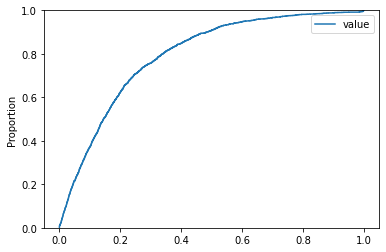

In [132]:
sns.ecdfplot(df_scaled_melt)

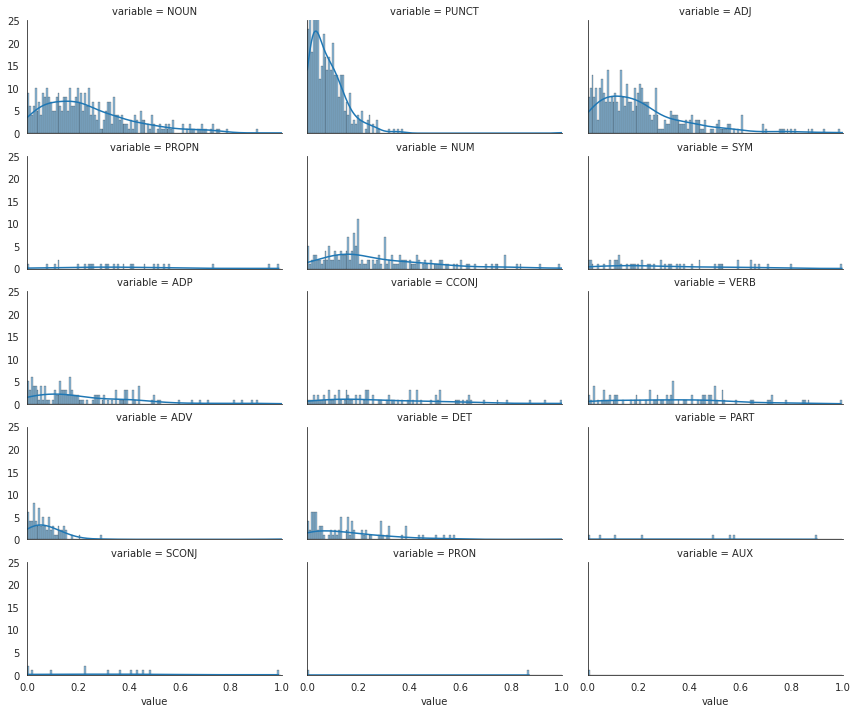

In [129]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df_scaled_melt, col='variable', col_wrap=3,
                      height=2, aspect=2, ylim=(0, 25), xlim=(0, 1))
g.map(sns.histplot, "value", kde=True,  bins=np.arange(0, 1, 0.0075))
#with sns.axes_style("white"):
#    g = sns.FacetGrid(df_scaled_melt, col='variable', col_wrap=3,
#                      height=2, aspect=2, ylim=(0, 1), xlim=(0, 1))
#g.map(sns.ecdfplot, "value",)


#g.set(xticks=[0, .25, .50,])
g.fig.subplots_adjust(wspace=.1, hspace=.2)

#g.savefig('PoS_distribution.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [79]:
df.T.agg(
    {column: ["min", "max", "median", "mean", "skew", "count"] for column in df.T.columns})

,NOUN,PUNCT,ADJ,PROPN,NUM,SYM,ADP,CCONJ,VERB,ADV,DET,PART,SCONJ,PRON,AUX
min,0.000075,0.000015,0.000368,0.005615,0.000017,0.000107,0.000097,0.000240,0.000520,0.000356,0.000169,0.002626,0.000482,0.001956,0.032453
max,0.418103,0.256511,0.310647,0.262376,0.250902,0.127057,0.123450,0.217858,0.241535,0.162732,0.109276,0.120634,0.103435,0.014823,0.032453
median,0.033361,0.014226,0.033629,0.108351,0.019453,0.014308,0.013908,0.024087,0.040254,0.022336,0.012063,0.016645,0.027260,0.008389,0.032453
mean,0.050454,0.025467,0.051448,0.106808,0.033835,0.022401,0.022141,0.040497,0.051544,0.039068,0.023660,0.036957,0.031475,0.008389,0.032453
skew,2.614891,2.984922,2.050112,0.505126,2.169697,2.083750,2.050000,1.875664,1.563469,1.329444,1.534703,1.317034,1.248758,NaN,NaN
count,385.000000,430.000000,393.000000,26.000000,183.000000,51.000000,126.000000,86.000000,83.000000,77.000000,89.000000,8.000000,13.000000,2.000000,1.000000
